In [1]:
import time
import copy
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns

from operator import truediv

import matplotlib.pyplot as plt
plt.style.use("dark_background")
plt.rcParams['savefig.dpi'] = 150
plt.rcParams.update({'figure.autolayout': True})

from sklearn.metrics import accuracy_score

from tqdm.autonotebook import tqdm

#Pytorch
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn, optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms, models, datasets

#Google Mount
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/My\ Drive/Classes/Covid_19_project/

#Utilities
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Mounted at /content/drive/
/content/drive/My Drive/Classes/Covid_19_project


In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
set_seed(42)

In [3]:
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'


dirs = {'test': test_dir,
        'train': train_dir, 
        'val': val_dir, 
       }

In [4]:
# add transforms to the data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.CenterCrop(224),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.CenterCrop(224),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

In [5]:
batch_size = 16

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'val', 'test']}

# load the data into batches
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle = True) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'val', 'test']}

In [6]:
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fd3178a3090>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fd2b2f54b90>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fd2b2f54cd0>}

In [7]:
dataset_sizes

{'test': 50, 'train': 812, 'val': 94}

In [8]:
class_names = image_datasets['train'].classes
print(class_names)

['covid_negative', 'covid_positive']


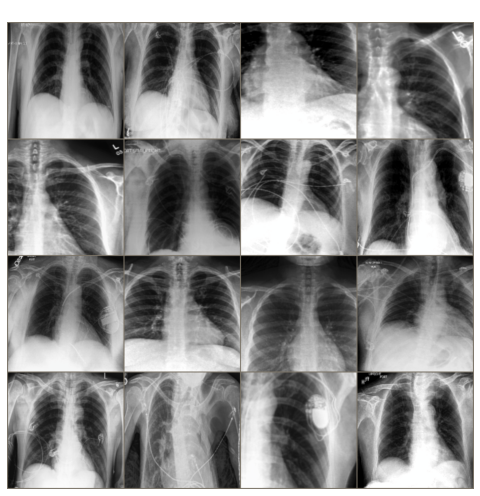

In [ ]:
def imshow(image):
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0))
    else:
        image = np.array(image).transpose((1, 2, 0))

    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.imshow(image)
    ax.axis('off') 
    plt.title('After transformation');
    #plt.savefig('images/transformed_images.png');
        
images, _ = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(images, nrow=4)
imshow(out)

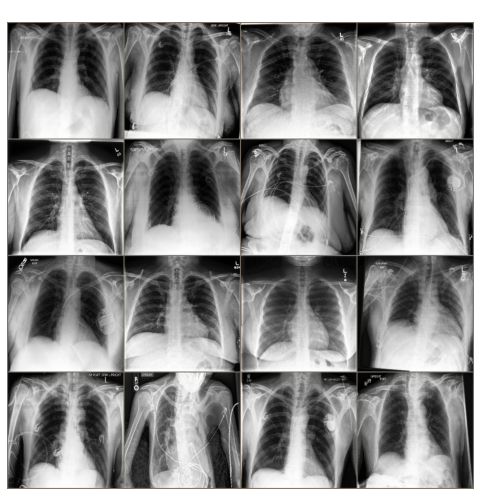

In [ ]:
def imshow(image):
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0))
    else:
        image = np.array(image).transpose((1, 2, 0))

    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.imshow(image)
    ax.axis('off') 
    plt.title('Before transformation');
    #plt.savefig('images/before_transformation.png');
        
images, _ = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(images, nrow=4)
imshow(out)

## Choose the pretrained model

In [9]:
resnet18_model = models.resnet18(pretrained=True)

num_features = resnet18_model.fc.in_features

# change the outputs from 512 to 2
resnet18_model.fc = nn.Linear(num_features, 2)

#unfreezing your model (for better accuracy)
for param in resnet18_model.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [63]:
resnet50_model = models.resnet50(pretrained=True)

num_features = resnet50_model.fc.in_features
# change the outputs from 512 to 2
resnet50_model.fc = nn.Linear(num_features, 2)

#unfreezing your model (for better accuracy)
for param in resnet50_model.parameters():
    param.requires_grad = True

In [11]:
densenet201_model = models.densenet201(pretrained=True)

# change the outputs from 1920 to 2
densenet201_model.classifier = nn.Linear(1920, 2)

#unfreezing your model (for better accuracy)
for param in densenet201_model.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


In [12]:
vgg16_model = models.vgg16(pretrained=True)

# change the outputs from 4096 to 2
vgg16_model.classifier[6] = nn.Linear(4096, 2)

#unfreezing your model (for better accuracy)
for param in vgg16_model.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [13]:
squeezenet_model = models.squeezenet1_0(pretrained=True)

# change the outputs from 512 to 2
squeezenet_model.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1,1), stride=(1,1))

#unfreezing your model (for better accuracy)
for param in squeezenet_model.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth


In [14]:
alexnet_model = models.alexnet(pretrained=True)

# change the outputs from 4096 to 2
alexnet_model.classifier[6] = nn.Linear(4096, 2)

#unfreezing your model (for better accuracy)
for param in alexnet_model.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [15]:
# Covid-ResNet model

class ResidualBlockE(nn.Module):
    def __init__(self, channels, kernel_size=3, leak_rate=0.1):
        super().__init__()
        #how much padding will our convolutional layers need to maintain the input shape
        pad = (kernel_size-1)//2
        
        #Define the conv an BN layers we will use
        self.conv1 = nn.Conv2d(channels, channels, kernel_size, padding=pad)
        self.bn1   = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size, padding=pad)
        self.bn2   = nn.BatchNorm2d(channels)
        #We need to pick an activation function. You can easily change this to try a different one!
        self.activation = nn.LeakyReLU(leak_rate)
     
    def forward(self, x):
        residual = x#save x as the residual value
        #apply the long path work
        x = self.conv1(self.activation(self.bn1(x)))
        x = self.conv2(self.activation(self.bn2(x)))
        #add the residual back in!
        x = x + residual
        return x
    
class ResidualBottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, leak_rate=0.1):
        super().__init__()
        #how much padding will our convolutional layers need to maintain the input shape
        pad = (kernel_size-1)//2
        #The botteneck should be smaller, so output/5 or input. You could try changing max to min
        bottleneck = max(out_channels//4, in_channels)
        #Define the three sets of BN and convolution layers we need. 
        #Notice that for the 1x1 convs we use padding=0, because 1x1 will not change shape! 
        self.bn1   = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, bottleneck, 1, padding=0)
        
        self.bn2   = nn.BatchNorm2d(bottleneck)
        self.conv2 = nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad)
        
        self.bn3   = nn.BatchNorm2d(bottleneck)
        self.conv3 = nn.Conv2d(bottleneck, out_channels, 1, padding=0)
        
        self.activation = nn.LeakyReLU(leak_rate)
        #By default, our shortcut will be the identiy function - which simply returns the input as the output
        self.shortcut = nn.Identity()
        #If we need to change the shape, then lets turn the shortcut into a small layer with 1x1 conv and BM
        if in_channels != out_channels:
            self.shortcut =  nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1, padding=0), 
                    nn.BatchNorm2d(out_channels)
                )
    
    def forward(self, x):
        residual = x#save the residual!
        #apply the long path
        x = self.conv1(self.activation(self.bn1(x)))
        x = self.conv2(self.activation(self.bn2(x)))
        x = self.conv3(self.activation(self.bn3(x)))
        #add the shortcut of the residual back in
        x = self.shortcut(residual) + x
        return x

In [16]:
#Whats the width and height of our images?
W, H = 224, 224
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 224*224 #224 * 224 images 
#Hidden layer size
n = 256 
#How many channels are in the input?
C = 3
#how many filters per convolutional layer
n_filters = 32
#How many classes are there?
classes = 2

leak_rate = 0.1

In [18]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [19]:
covid_resnet_model = nn.Sequential(
    ResidualBottleNeck(C, n_filters),
    ResidualBlockE(n_filters),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)),
    ResidualBottleNeck(n_filters, 2*n_filters),
    nn.LeakyReLU(leak_rate),
    ResidualBlockE(2*n_filters),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)),
    ResidualBottleNeck(2*n_filters, 4*n_filters),
    nn.LeakyReLU(leak_rate),
    ResidualBlockE(4*n_filters),
    nn.LeakyReLU(leak_rate),
    Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

In [20]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs. 
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary. 
    desc -- a description to use for the progress bar.     
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

In [21]:
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

In [22]:
def train_network(model, loss_func, train_loader, val_loader=None, test_loader=None, score_funcs=None, 
                  epochs=50, device="cpu", checkpoint_file=None, 
                  lr_schedule=None, optimizer=None, disable_tqdm=False):
  
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    lr_schedule -- the learning rate schedule used to alter \eta as the model trains. If this is not None than the user must also provide the optimizer to use. 
    optimizer -- the method used to alter the gradients for learning. 
    """

    if score_funcs == None:
        score_funcs = {} #Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        if test_loader is not None:
            to_track.append("test "+ eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}

    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        
      
        if val_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Validating")
                
        #In PyTorch, the convention is to update the learning rate after every epoch
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(results["val loss"][-1])
            else:
                lr_schedule.step()
                
        if test_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)

    return pd.DataFrame.from_dict(results)


In [23]:
#Confusion matrix function

def confusion_matrix(nb_classes, loader, model):
  confusion_matrix = np.zeros((nb_classes, nb_classes))

  with torch.no_grad():
    for i, (inputs, classes) in enumerate(loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

  return confusion_matrix

In [24]:
# DF for best epochs collection and visualization
best_epoch_df = pd.DataFrame() 

# DF for Precision and Recall collection and visualization
precision_recall_df = pd.DataFrame(columns = ['Model', 'Precision 0', 'Precision 1', 'Recall 0', 'Recall 1'])

In [25]:
# Parameters of the network

epochs = 30
lr = 0.01
loss_func = nn.CrossEntropyLoss()

## Resnet18

In [26]:
resnet18_results = train_network(resnet18_model, loss_func, dataloaders['train'], val_loader = dataloaders['val'],
                        epochs = epochs, optimizer = torch.optim.SGD(resnet18_model.parameters(), lr = lr), 
                        checkpoint_file = 'best_models/resnet18.pth', score_funcs = {'Accuracy': accuracy_score}, device = device)

Precision: [0.9791666666666666, 1.0]
Recall: [1.0, 0.9787234042553191]


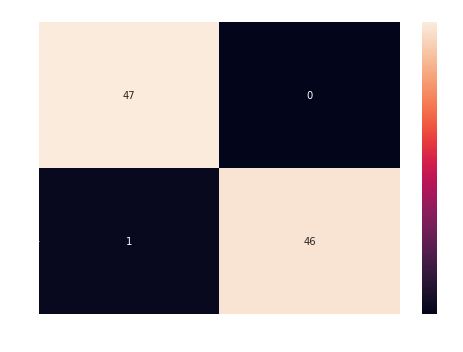

In [27]:
conf = confusion_matrix(2, dataloaders['val'], resnet18_model)

tp = np.diag(conf)
prec = list(map(truediv, tp, np.sum(conf, axis=0))) # precision
rec = list(map(truediv, tp, np.sum(conf, axis=1))) # recall
print ('Precision: {}\nRecall: {}'.format(prec, rec))

plt.figure(figsize=(7,5))
df_cm = pd.DataFrame(conf, index=class_names).astype(int) #confusion matrix plot
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

plt.title('Resnet18')
plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.savefig('images/confusion_matrix/Resnet18.png');

In [28]:
resnet18_results = resnet18_results.assign(Model='Resnet18')

best_epoch_df = best_epoch_df.append(resnet18_results.loc[resnet18_results['val Accuracy'].idxmax()])

precision_recall_df = precision_recall_df.append({'Model' : 'Resnet18', 'Precision 0' : prec[0], 'Precision 1' : prec[1],
                                                'Recall 0' : rec[0], 'Recall 1' : rec[1] },  
                ignore_index = True) 

## Resnet50

In [31]:
resnet50_results = train_network(resnet50_model, loss_func, dataloaders['train'], val_loader = dataloaders['val'],
                        epochs = epochs, optimizer = torch.optim.SGD(resnet50_model.parameters(), lr = lr), 
                        checkpoint_file = 'best_models/resnet50.pth', score_funcs = {'Accuracy': accuracy_score}, device = device)

Precision: [1.0, 1.0]
Recall: [1.0, 1.0]


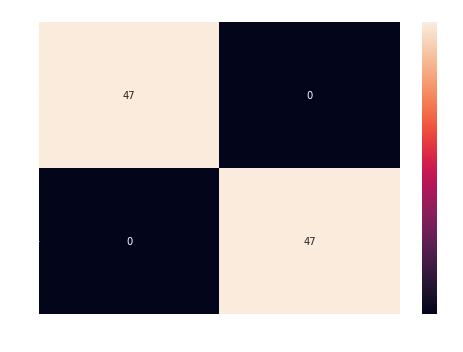

In [32]:
conf = confusion_matrix(2, dataloaders['val'], resnet50_model)

tp = np.diag(conf)
prec = list(map(truediv, tp, np.sum(conf, axis=0))) # precision
rec = list(map(truediv, tp, np.sum(conf, axis=1))) # recall
print ('Precision: {}\nRecall: {}'.format(prec, rec))

plt.figure(figsize=(7,5))
df_cm = pd.DataFrame(conf, index=class_names).astype(int) #confusion matrix plot
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

plt.title('Resnet50')
plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.savefig('images/confusion_matrix/Resnet50.png');

In [33]:
resnet50_results = resnet50_results.assign(Model='Resnet50')

best_epoch_df = best_epoch_df.append(resnet50_results.loc[resnet50_results['val Accuracy'].idxmax()])

precision_recall_df = precision_recall_df.append({'Model' : 'Resnet50', 'Precision 0' : prec[0], 'Precision 1' : prec[1],
                                                'Recall 0' : rec[0], 'Recall 1' : rec[1] },  
                ignore_index = True) 

## Densenet201

In [34]:
densenet201_results = train_network(densenet201_model, loss_func, dataloaders['train'], val_loader = dataloaders['val'],
                        epochs = epochs, optimizer = torch.optim.SGD(densenet201_model.parameters(), lr = lr), 
                        checkpoint_file = 'best_models/densenet201.pth', score_funcs = {'Accuracy': accuracy_score}, device = device)

Precision: [1.0, 1.0]
Recall: [1.0, 1.0]


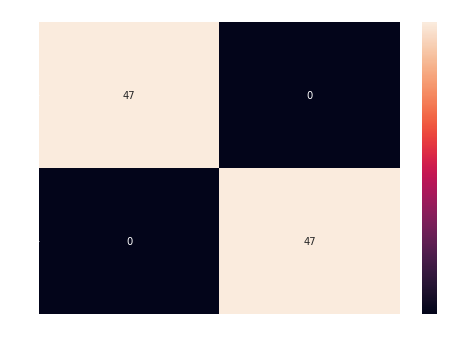

In [35]:
conf = confusion_matrix(2, dataloaders['val'], densenet201_model)

tp = np.diag(conf)
prec = list(map(truediv, tp, np.sum(conf, axis=0))) # precision
rec = list(map(truediv, tp, np.sum(conf, axis=1))) # recall
print ('Precision: {}\nRecall: {}'.format(prec, rec))

plt.figure(figsize=(7,5))
df_cm = pd.DataFrame(conf, index=class_names).astype(int) #confusion matrix plot
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

plt.title('Densenet201')
plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.savefig('images/confusion_matrix/Densenet201.png');

In [36]:
densenet201_results = densenet201_results.assign(Model='Densenet201')

best_epoch_df = best_epoch_df.append(densenet201_results.loc[densenet201_results['val Accuracy'].idxmax()])

precision_recall_df = precision_recall_df.append({'Model' : 'Densenet201', 'Precision 0' : prec[0], 'Precision 1' : prec[1],
                                                'Recall 0' : rec[0], 'Recall 1' : rec[1] },  
                ignore_index = True) 

## Squeezenet

In [37]:
squeezenet_results = train_network(squeezenet_model, loss_func, dataloaders['train'], val_loader = dataloaders['val'],
                        epochs = epochs, optimizer = torch.optim.SGD(squeezenet_model.parameters(), lr = lr), 
                        checkpoint_file = 'best_models/squeezenet.pth', score_funcs = {'Accuracy': accuracy_score}, device = device)

Precision: [1.0, 0.9591836734693877]
Recall: [0.9574468085106383, 1.0]


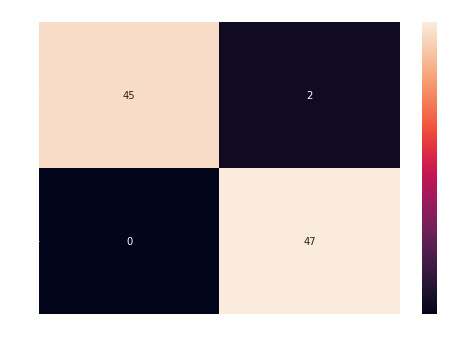

In [38]:
conf = confusion_matrix(2, dataloaders['val'], squeezenet_model)

tp = np.diag(conf)
prec = list(map(truediv, tp, np.sum(conf, axis=0))) # precision
rec = list(map(truediv, tp, np.sum(conf, axis=1))) # recall
print ('Precision: {}\nRecall: {}'.format(prec, rec))

plt.figure(figsize=(7,5))
df_cm = pd.DataFrame(conf, index=class_names).astype(int) #matrix plot
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

plt.title('Squeezenet')
plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.savefig('images/confusion_matrix/Squeezenet.png');

In [39]:
squeezenet_results = squeezenet_results.assign(Model='Squeezenet')

best_epoch_df = best_epoch_df.append(squeezenet_results.loc[squeezenet_results['val Accuracy'].idxmax()])

precision_recall_df = precision_recall_df.append({'Model' : 'Squeezenet', 'Precision 0' : prec[0], 'Precision 1' : prec[1],
                                                'Recall 0' : rec[0], 'Recall 1' : rec[1] },  
                ignore_index = True) 

## VGG16

In [40]:
vgg16_results = train_network(vgg16_model, loss_func, dataloaders['train'], val_loader = dataloaders['val'],
                        epochs = epochs, optimizer = torch.optim.SGD(vgg16_model.parameters(), lr = lr), 
                        checkpoint_file = 'best_models/vgg16.pth', score_funcs = {'Accuracy': accuracy_score}, device = device)

Precision: [1.0, 1.0]
Recall: [1.0, 1.0]


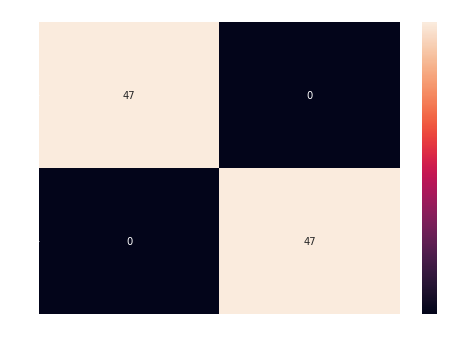

In [41]:
conf = confusion_matrix(2, dataloaders['val'], vgg16_model)

tp = np.diag(conf)
prec = list(map(truediv, tp, np.sum(conf, axis=0))) # precision
rec = list(map(truediv, tp, np.sum(conf, axis=1))) # recall
print ('Precision: {}\nRecall: {}'.format(prec, rec))

plt.figure(figsize=(7,5))
df_cm = pd.DataFrame(conf, index=class_names).astype(int) #matrix plot
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

plt.title('VGG16')
plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.savefig('images/confusion_matrix/VGG16.png');

In [42]:
vgg16_results = vgg16_results.assign(Model='VGG16')

best_epoch_df = best_epoch_df.append(vgg16_results.loc[vgg16_results['val Accuracy'].idxmax()])

precision_recall_df = precision_recall_df.append({'Model' : 'VGG16', 'Precision 0' : prec[0], 'Precision 1' : prec[1],
                                                'Recall 0' : rec[0], 'Recall 1' : rec[1] },  
                ignore_index = True) 

## AlexNet

In [43]:
alexnet_results = train_network(alexnet_model, loss_func, dataloaders['train'], val_loader = dataloaders['val'],
                        epochs = epochs, optimizer = torch.optim.SGD(alexnet_model.parameters(), lr = lr), 
                        checkpoint_file = 'best_models/alexnet.pth', score_funcs = {'Accuracy': accuracy_score}, device = device)

Precision: [0.9038461538461539, 1.0]
Recall: [1.0, 0.8936170212765957]


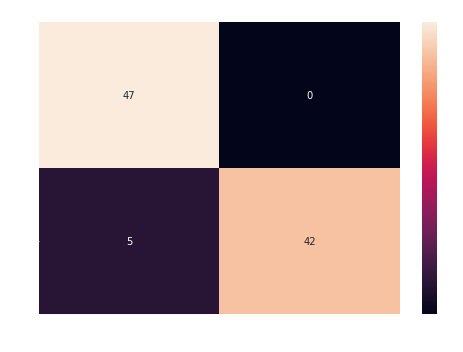

In [44]:
conf = confusion_matrix(2, dataloaders['val'], alexnet_model)

tp = np.diag(conf)
prec = list(map(truediv, tp, np.sum(conf, axis=0))) # precision
rec = list(map(truediv, tp, np.sum(conf, axis=1))) # recall
print ('Precision: {}\nRecall: {}'.format(prec, rec))

plt.figure(figsize=(7,5))
df_cm = pd.DataFrame(conf, index=class_names).astype(int) #matrix plot
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

plt.title('Alexnet')
plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.savefig('images/confusion_matrix/Alexnet.png');

In [45]:
alexnet_results = alexnet_results.assign(Model='Alexnet')

best_epoch_df = best_epoch_df.append(alexnet_results.loc[alexnet_results['val Accuracy'].idxmax()])

precision_recall_df = precision_recall_df.append({'Model' : 'VGG16', 'Precision 0' : prec[0], 'Precision 1' : prec[1],
                                                'Recall 0' : rec[0], 'Recall 1' : rec[1] },  
                ignore_index = True) 

## Covid-ResNet



In [46]:
covid_resnet_results = train_network(covid_resnet_model, loss_func, dataloaders['train'], val_loader = dataloaders['val'], 
                        epochs = epochs, optimizer = torch.optim.SGD(covid_resnet_model.parameters(), lr = lr), 
                        checkpoint_file = 'best_models/covid_resnet.pth', score_funcs = {'Accuracy': accuracy_score}, 
                        device = device)

Precision: [0.94, 1.0]
Recall: [1.0, 0.9361702127659575]


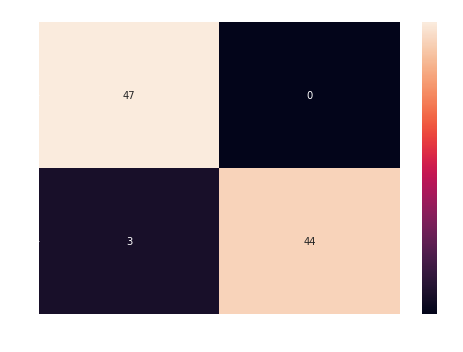

In [47]:
conf = confusion_matrix(2, dataloaders['val'], covid_resnet_model)

tp = np.diag(conf)
prec = list(map(truediv, tp, np.sum(conf, axis=0))) # precision
rec = list(map(truediv, tp, np.sum(conf, axis=1))) # recall
print ('Precision: {}\nRecall: {}'.format(prec, rec))

plt.figure(figsize=(7,5))
df_cm = pd.DataFrame(conf, index=class_names).astype(int) #matrix plot
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

plt.title('Covid-ResNet')
plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.savefig('images/confusion_matrix/Covid-ResNet.png');

In [48]:
covid_resnet_results = covid_resnet_results.assign(Model='Covid-ResNet')

best_epoch_df = best_epoch_df.append(covid_resnet_results.loc[covid_resnet_results['val Accuracy'].idxmax()])

precision_recall_df = precision_recall_df.append({'Model' : 'Covid-ResNet', 'Precision 0' : prec[0], 'Precision 1' : prec[1],
                                                'Recall 0' : rec[0], 'Recall 1' : rec[1] },  
                ignore_index = True) 

In [49]:
best_epoch_df

,Model,epoch,total time,train Accuracy,train loss,val Accuracy,val loss
10,Resnet18,10.0,958.935756,0.949507,0.137641,1.000000,0.021337
3,Resnet50,3.0,171.069403,0.944581,0.135481,1.000000,0.039140
8,Densenet201,8.0,551.934362,0.967980,0.081122,1.000000,0.016114
27,Squeezenet,27.0,872.586343,0.934729,0.157708,0.978723,0.067785
5,VGG16,5.0,300.514571,0.951970,0.118213,1.000000,0.022469
15,Alexnet,15.0,482.256922,0.944581,0.153257,1.000000,0.031159
15,Covid-ResNet,15.0,733.102443,0.843596,0.673138,0.957447,0.094939


In [50]:
precision_recall_df

,Model,Precision 0,Precision 1,Recall 0,Recall 1
0,Resnet18,0.979167,1.000000,1.000000,0.978723
1,Resnet50,1.000000,1.000000,1.000000,1.000000
2,Densenet201,1.000000,1.000000,1.000000,1.000000
3,Squeezenet,1.000000,0.959184,0.957447,1.000000
4,VGG16,1.000000,1.000000,1.000000,1.000000
5,VGG16,0.903846,1.000000,1.000000,0.893617
6,Covid-ResNet,0.940000,1.000000,1.000000,0.936170


In [51]:
best_model = best_epoch_df[['Model', 'val Accuracy']]
best_model = best_model.reset_index()
best_model = best_model.drop(['index'], axis=1)
best_model

,Model,val Accuracy
0,Resnet18,1.000000
1,Resnet50,1.000000
2,Densenet201,1.000000
3,Squeezenet,0.978723
4,VGG16,1.000000
5,Alexnet,1.000000
6,Covid-ResNet,0.957447


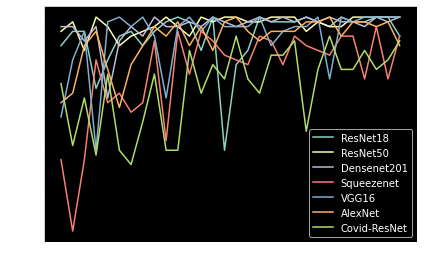

In [52]:
sns.lineplot(x = 'epoch', y = 'val Accuracy', data = resnet18_results, label = 'ResNet18');
sns.lineplot(x = 'epoch', y = 'val Accuracy', data = resnet50_results, label = 'ResNet50');
sns.lineplot(x = 'epoch', y = 'val Accuracy', data = densenet201_results, label = 'Densenet201');
sns.lineplot(x = 'epoch', y = 'val Accuracy', data = squeezenet_results, label = 'Squeezenet');
sns.lineplot(x = 'epoch', y = 'val Accuracy', data = vgg16_results, label = 'VGG16');
sns.lineplot(x = 'epoch', y = 'val Accuracy', data = alexnet_results, label = 'AlexNet');
sns.lineplot(x = 'epoch', y = 'val Accuracy', data = covid_resnet_results, label = 'Covid-ResNet');
plt.savefig('images/training_30epochs.png');

# Prediction

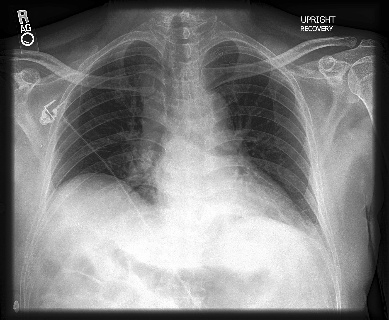

In [108]:
test_img = Image.open('data/view1_frontal.jpg0.42029574838014594.jpg').convert('RGB')
test_img

In [109]:
checkpoint_covid_net = torch.load('best_models/covid_resnet.pth')

In [110]:
def load_checkpoint(model, checkpoint, filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model

In [111]:
model = load_checkpoint(covid_resnet_model, checkpoint_covid_net, 'best_models/covid_resnet.pth')
#print(model)

In [112]:
image_preprocess = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.CenterCrop(224),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

# Pass the image for preprocessing
img_preprocessed = image_preprocess(test_img).cuda()

# Reshape, crop, and normalize the input tensor for feeding into network for evaluation
img_tensor = torch.unsqueeze(img_preprocessed, 0)

In [113]:
out = model(img_tensor)
out

tensor([[ 1.5326, -1.5041]], device='cuda:0')

In [114]:
_, index = torch.max(out, 1)

percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

covid_negative 95.42073059082031


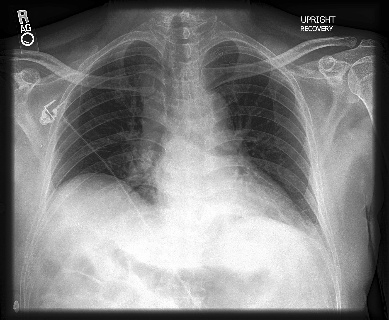

In [115]:
print(class_names[index[0]], percentage[index[0]].item())
test_img

## Views of sample images

tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1])


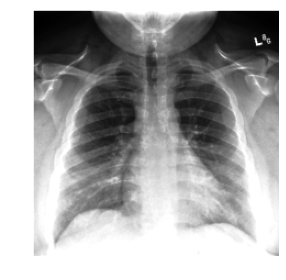

In [ ]:
images, labels = next(iter(dataloaders['test']))
plt.imshow(images[0][0], cmap=plt.get_cmap('gray'));
print(labels)

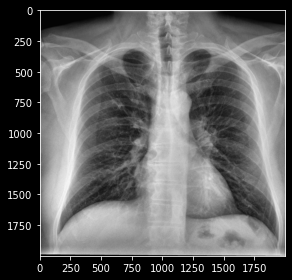

In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread('data/test/covid_positive/8fc103ca.jpg')
imgplot = plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()